# Classification and Scoring analysis for Data Engineering position

---

We'll define the model to train a resume classifier for **Data Engineering** position.

First, a data set for training will be defined in this same repository. The training data consists in several data engineering job descriptions found through different job search platforms.

---
## 1. Data Preparation

---
#### 1.1 Helper Function Definitions

In [27]:
import spacy

nlp = spacy.load('en_core_web_md')
position = 'data_engineering'


# Some helper functions
def clean_text(text, lemma=False):
    # Tokenize
    doc = nlp(text)
    
    # Remove Stopwords
    tokens = [token for token in doc if not (token.is_stop or token.is_punct) ]
    
    # Lemmatisation
    if lemma == True:
        tokens = [token.lemma_.strip().lower()  for token in tokens if token.lemma_.strip()]
    else:
        tokens = [token.text.strip().lower() for token in tokens if token.text.strip()]
    
    return ' '.join(tokens)

def get_metrics(df):

    DE_TP = df[(df['predicted'] == df[position]) & (df['predicted'] == 1)]
    DE_TN = df[(df['predicted'] == df[position]) & (df['predicted'] == 0)]
    DE_FP = df[(df['predicted'] != df[position]) & (df['predicted'] == 1)]
    DE_FN = df[(df['predicted'] != df[position]) & (df['predicted'] == 0)]
    
    print(f'TP: {len(DE_TP)} TN: {len(DE_TN)} FP: {len(DE_FP)} FN: {len(DE_FN)}')
    accuracy = (len(DE_TP)+len(DE_TN)) / len(df)
    precision = len(DE_TP)/((len(DE_TP)+len(DE_FP)) if (len(DE_TP)+len(DE_FP)) > 0 else 1)
    recall = len(DE_TP)/(len(DE_TP)+len(DE_FN))
    f1 = 2*(precision*recall)/((precision+recall) if precision+recall > 0 else 1)
    
    
    return accuracy, precision, recall, f1


def test_real_resumes(model ,models):
    import os

    # Loading and preparing real Resumes data
    candidates_df = pd.read_csv(os.path.join(testing_files_dir, 'candidates.csv'))
    candidates_df = candidates_df.dropna()
    candidates_df.rename(columns={'data_engineer':'data_engineering'}, inplace=True)
    candidates_df = candidates_df[candidates_df[['data_engineering', 'frontend', 'sdet']].any(axis=1)]

    # Predicting for real Resumes
    candidates_df['predicted'] = models[model].predict(candidates_df['text'])
    candidates_df['predicted_probs'] = tuple(models[model].predict_proba(candidates_df['text']))

    # Taking out resumes with no specific real classification (for now)
    print('Metrics for [', position, '] using model: [', model, ']\n')
    # Calculate metrics
    accuracy, precision, recall, f1 = get_metrics(candidates_df)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1}')
    
    return candidates_df


def compare_models(models):
    # Loading and preparing real Resumes data
    candidates_df = pd.read_csv(os.path.join(testing_files_dir, 'candidates.csv'))
    candidates_df = candidates_df.dropna()
    candidates_df.rename(columns={'data_engineer':'data_engineering'}, inplace=True)
    candidates_df = candidates_df[candidates_df[['data_engineering', 'frontend', 'sdet']].any(axis=1)]
    
    predictions = pd.DataFrame()
    predictions['metrics'] = ['accuracy', 'precision', 'recall', 'f1-score']
    predictions = predictions.set_index('metrics')
    for name, model in models.items():
        temp = candidates_df.copy()
        temp['predicted'] = model.predict(candidates_df['text'])
        temp['predicted_probs'] = tuple(model.predict_proba(candidates_df['text']))
        
        accuracy, precision, recall, f1 = get_metrics(temp)
        predictions[name] = [accuracy, precision, recall, f1]
    
    return predictions

---
#### 1.2 Data Load and Preprocessing

In [2]:
import pandas as pd
import os

# Defining the directories to use
training_files_dir = './training_data'
testing_files_dir = './data/testing'
training_file = position + '.csv'

valid_formats = ['txt', 'doc', 'docx', 'rtf', 'pdf']

# Loading the file containing the training info
df = pd.read_csv(os.path.join(training_files_dir, training_file))
print('Cleaning null registries...')
df.isna().sum()
print('Cleaning text for each registry...')
df['corpus'] = df['description'].apply(lambda x: clean_text(x,lemma=True))

Cleaning null registries...
Cleaning text for each registry...


---
#### 1.3 Datasets Preparation

In [3]:
from sklearn.model_selection import train_test_split

# Separating training and test data
y = df['tag'].values

df_train, df_test = train_test_split(df, test_size=0.25, random_state=1000)

y_train = df_train['tag']
y_test = df_test['tag']

---
#### 1.4 Vectorizer

Text(0.5, 1.0, 'Sparse Matrix Sample')

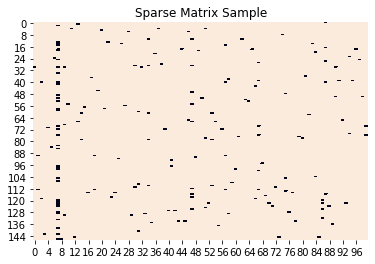

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np


corpus = df_train['corpus']
# BoW
vectorizer = CountVectorizer(ngram_range=(1,2))
# TD-IDF
#vectorizer = TfidfVectorizer(ngram_range=(1,2))

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

---
## 2. Models Analysis
---
#### 2.1 Logistic Regression Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

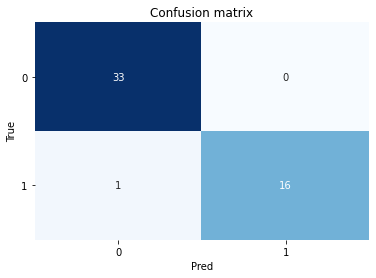

In [5]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import pipeline, preprocessing
from sklearn import metrics


models = {}

classifier = LogisticRegression()
model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', classifier)])
    
model['classifier'].fit(X_train, y_train)
models['LogisticRegression'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.2 SGDClassifier Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

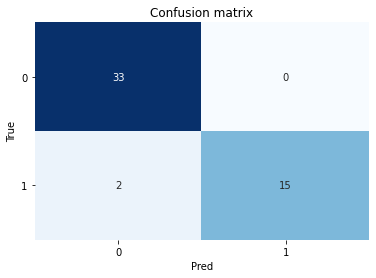

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV 


classifier = SGDClassifier()
classifier = classifier.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(classifier, cv='prefit')

model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', calibrator)])
    
model['classifier'].fit(X_train, y_train)
models['SGDClassifier'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.3 SVC Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

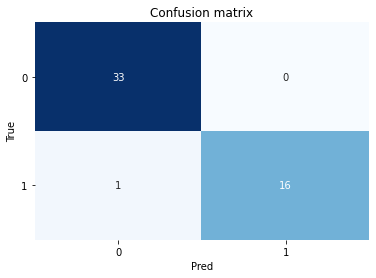

In [7]:
from sklearn.svm import SVC


classifier = SVC(probability=True)
model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', classifier)])
    
model['classifier'].fit(X_train, y_train)
models['SVC'] = model
    
X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.4 Naive Bayes

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

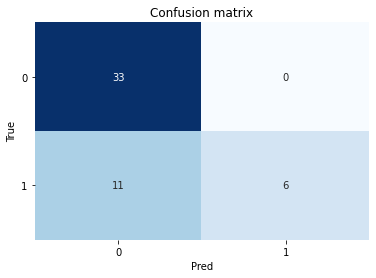

In [8]:
from sklearn import naive_bayes, pipeline, manifold, preprocessing

from sklearn import metrics
import matplotlib.pyplot as plt

classifier = naive_bayes.BernoulliNB()
model = pipeline.Pipeline([('vectorizer', vectorizer),
                           ('classifier', classifier)])

model['classifier'].fit(X_train, y_train)
models['NaiveBayes'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)


accuracy = metrics.accuracy_score(y_test.values, predicted)
auc = metrics.roc_auc_score(y_test.values, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.5 Comparing Metrics with Real Resumes

In [9]:
df = test_real_resumes('LogisticRegression', models)
df[df['data_engineering'] == 1]

Metrics for [ data_engineering ] using model: [ LogisticRegression ]

TP: 11 TN: 50 FP: 0 FN: 2
Accuracy: 0.9682539682539683
Precision: 1.0
Recall: 0.8461538461538461
F1-score: 0.9166666666666666


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
0,aaron_castillo,1,0,0,aarón martín castillo chabacano 1 colonia loma...,1,"(0.0024316266397693687, 0.9975683733602306)"
1,dennys-regalado,1,0,0,dennys regalado data engineer dennys dedicated...,1,"(4.357501726115487e-08, 0.9999999564249827)"
2,dennys_regalado_2,1,0,0,resume data engineer drive architectural desig...,1,"(1.4905854328617352e-11, 0.9999999999850941)"
4,Luis_Enrique_Márquez_Sampayo,1,0,0,ph e. 21 4 0 22 emai luis.marquez@gmail.com l ...,1,"(0.17551173953850563, 0.8244882604614944)"
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,1,"(0.03977603921522366, 0.9602239607847763)"
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,0,"(0.8259471772764031, 0.17405282272359696)"
29,Eiffel_Neftali_Antuna_Rodríguez,1,0,0,eiffel neftali antuna rodríguez phone 33)16942...,1,"(4.839982173154844e-06, 0.9999951600178268)"
31,Enrique_Garcia_Rosales,1,1,0,contact nitos_san@hotmail.com www.linkedin.com...,1,"(2.7919214054206165e-05, 0.9999720807859458)"
36,Francisco_José_Villalobos_Salcido,1,0,0,francisco josé villalobos salcido data enginee...,1,"(0.007795530300447551, 0.9922044696995524)"
48,Javier_Zepeda,1,0,0,javier zepeda summary experience 14 year exper...,1,"(0.00031349207829822756, 0.9996865079217018)"


In [10]:
df = test_real_resumes('SGDClassifier', models)
df[df['data_engineering'] == 1]

Metrics for [ data_engineering ] using model: [ SGDClassifier ]

TP: 10 TN: 46 FP: 4 FN: 3
Accuracy: 0.8888888888888888
Precision: 0.7142857142857143
Recall: 0.7692307692307693
F1-score: 0.7407407407407408


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
0,aaron_castillo,1,0,0,aarón martín castillo chabacano 1 colonia loma...,1,"(0.0052358332697891585, 0.9947641667302108)"
1,dennys-regalado,1,0,0,dennys regalado data engineer dennys dedicated...,1,"(7.829664543401726e-05, 0.999921703354566)"
2,dennys_regalado_2,1,0,0,resume data engineer drive architectural desig...,1,"(1.2630836307980786e-06, 0.9999987369163692)"
4,Luis_Enrique_Márquez_Sampayo,1,0,0,ph e. 21 4 0 22 emai luis.marquez@gmail.com l ...,1,"(0.12864528392564656, 0.8713547160743534)"
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,0,"(0.8273067844374632, 0.1726932155625368)"
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,0,"(0.8029468036738112, 0.19705319632618878)"
29,Eiffel_Neftali_Antuna_Rodríguez,1,0,0,eiffel neftali antuna rodríguez phone 33)16942...,1,"(0.003556535035674102, 0.9964434649643259)"
31,Enrique_Garcia_Rosales,1,1,0,contact nitos_san@hotmail.com www.linkedin.com...,1,"(0.0008583549477219066, 0.9991416450522781)"
36,Francisco_José_Villalobos_Salcido,1,0,0,francisco josé villalobos salcido data enginee...,1,"(0.003917801414175082, 0.9960821985858249)"
48,Javier_Zepeda,1,0,0,javier zepeda summary experience 14 year exper...,0,"(0.9998201241329034, 0.00017987586709661065)"


In [11]:
df = test_real_resumes('SVC', models)
df[df['data_engineering'] == 1]

Metrics for [ data_engineering ] using model: [ SVC ]

TP: 9 TN: 50 FP: 0 FN: 4
Accuracy: 0.9365079365079365
Precision: 1.0
Recall: 0.6923076923076923
F1-score: 0.8181818181818181


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
0,aaron_castillo,1,0,0,aarón martín castillo chabacano 1 colonia loma...,1,"(0.006066206042139848, 0.9939337939578602)"
1,dennys-regalado,1,0,0,dennys regalado data engineer dennys dedicated...,1,"(1.0926129112860346e-06, 0.9999989073870887)"
2,dennys_regalado_2,1,0,0,resume data engineer drive architectural desig...,1,"(0.1252991342636266, 0.8747008657363733)"
4,Luis_Enrique_Márquez_Sampayo,1,0,0,ph e. 21 4 0 22 emai luis.marquez@gmail.com l ...,0,"(0.3077913638119737, 0.6922086361880262)"
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,1,"(0.17618242443289123, 0.8238175755671087)"
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,0,"(0.7805257196030302, 0.21947428039696978)"
29,Eiffel_Neftali_Antuna_Rodríguez,1,0,0,eiffel neftali antuna rodríguez phone 33)16942...,1,"(0.039521137404831416, 0.9604788625951685)"
31,Enrique_Garcia_Rosales,1,1,0,contact nitos_san@hotmail.com www.linkedin.com...,1,"(0.25162944274720106, 0.7483705572527986)"
36,Francisco_José_Villalobos_Salcido,1,0,0,francisco josé villalobos salcido data enginee...,1,"(0.007893175479313673, 0.9921068245206864)"
48,Javier_Zepeda,1,0,0,javier zepeda summary experience 14 year exper...,0,"(0.529103264359278, 0.4708967356407219)"


In [12]:
df = test_real_resumes('NaiveBayes', models)
df[df['data_engineering'] == 1]

Metrics for [ data_engineering ] using model: [ NaiveBayes ]

TP: 1 TN: 50 FP: 0 FN: 12
Accuracy: 0.8095238095238095
Precision: 1.0
Recall: 0.07692307692307693
F1-score: 0.14285714285714288


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
0,aaron_castillo,1,0,0,aarón martín castillo chabacano 1 colonia loma...,0,"(1.0, 2.942780817675514e-39)"
1,dennys-regalado,1,0,0,dennys regalado data engineer dennys dedicated...,0,"(0.9727683184927256, 0.027231681507295546)"
2,dennys_regalado_2,1,0,0,resume data engineer drive architectural desig...,1,"(6.318526683408189e-16, 1.0)"
4,Luis_Enrique_Márquez_Sampayo,1,0,0,ph e. 21 4 0 22 emai luis.marquez@gmail.com l ...,0,"(1.0, 1.1848285827983617e-79)"
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,0,"(1.0, 1.5005411290903593e-79)"
6,Aaron_Hazel_Martinez_San_Roman,1,1,0,aaron hazel martinez san roman systems enginee...,0,"(1.0, 1.0465810282512831e-97)"
29,Eiffel_Neftali_Antuna_Rodríguez,1,0,0,eiffel neftali antuna rodríguez phone 33)16942...,0,"(1.0, 1.6326558634944089e-50)"
31,Enrique_Garcia_Rosales,1,1,0,contact nitos_san@hotmail.com www.linkedin.com...,0,"(1.0, 7.309137866851836e-59)"
36,Francisco_José_Villalobos_Salcido,1,0,0,francisco josé villalobos salcido data enginee...,0,"(1.0, 6.182360163085537e-89)"
48,Javier_Zepeda,1,0,0,javier zepeda summary experience 14 year exper...,0,"(0.9999999999608917, 3.9302662462633575e-11)"


---
#### 2.6 Choosing the Model

In [13]:
compare_models(models)

TP: 11 TN: 50 FP: 0 FN: 2
TP: 10 TN: 46 FP: 4 FN: 3
TP: 9 TN: 50 FP: 0 FN: 4
TP: 1 TN: 50 FP: 0 FN: 12


,LogisticRegression,SGDClassifier,SVC,NaiveBayes
metrics,,,,
accuracy,0.968254,0.888889,0.936508,0.809524
precision,1.000000,0.714286,1.000000,1.000000
recall,0.846154,0.769231,0.692308,0.076923
f1-score,0.916667,0.740741,0.818182,0.142857


In [26]:
deploy_dir = '../app/models'
model_to_deploy = 'LogisticRegression'

pd.to_pickle(models[model_to_deploy], os.path.join(deploy_dir, '.'.join([position, 'pickle'])))